In [1]:
import drdf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_drdf(fname):
  reader = drdf.DRDF()
  reader.read(fname)
  events = []
  for run in reader.runs:
    for event in reader.runs[run]:
      hits_map = dict()
      for cam, img in reader.runs[run][event].items():
        amplitude = img.pixels[:, :, 0] 
        time = img.pixels[:, :, 1]
        hits_map[cam] = amplitude
      events.append((event, hits_map))
  return events

In [3]:
file_drdf_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/response_1.drdf", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/response_2.drdf"]
file_root_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/input_files/sensors_1.root", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/input_files/sensors_2.root"]

In [4]:
more_drdf_files = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/response_3.drdf", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/response_4.drdf", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/response_5.drdf", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/response_6.drdf", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/response_7.drdf", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/response_8.drdf", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/response_9.drdf", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/response_10.drdf"]
more_root_files = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/input_files/sensors_3.root", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/input_files/sensors_4.root", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/input_files/sensors_5.root", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/input_files/sensors_6.root", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/input_files/sensors_7.root", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/input_files/sensors_8.root", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/input_files/sensors_9.root", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/ML_blindcameras_10-01/input_files/sensors_10.root"]

In [5]:
def CamList(fname):
    cam_list = []
    file = load_drdf(fname)
    for cam in file[0][1]:
        cam_list.append(cam)
    return cam_list

In [6]:
#creo una matrice 1000 righe x 54 colonne. ogni elemento è una camera 32x32
def AllImages(fname): 
    all_images_list = []
    cam_list = CamList(fname)
    file = load_drdf(fname)
    for i in range(len(file)):
        ph_matrix = []
        for cam in cam_list:
            ph_matrix.append(file[i][1][cam])
        all_images_list.append(ph_matrix)
    all_images = np.array(all_images_list)
    return all_images

In [7]:
def DimensionsData(fname):
    file = AllImages(fname)
    dimension_data = {"nr_events" : len(file), "nr_pixels" : len(file[0][0]), "nr_cams" : len(file[0]), "nr_tot_events" : len(file[0])*len(file)}
    return dimension_data

In [8]:
def PlotCamsImages(fname):
    all_images = AllImages(fname)
    file = load_drdf(fname)
    cam_list = CamList(fname)
    for i in range(len(all_images)):
        #for cam in cam_list:
        for j in range(len(all_images[i])):
            plt.imshow(all_images[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()

In [9]:
def Preprocessing(fname):
    matrix = AllImages(fname)
    dimension_data = DimensionsData(fname)
    images = matrix.reshape(dimension_data["nr_tot_events"], dimension_data["nr_pixels"], dimension_data["nr_pixels"])
    return images

In [10]:
def SumPhotons(fname):
    tot_photons = []
    all_images = Preprocessing(fname)
    for j in all_images:
        sum_ph = np.sum(j)
        tot_photons.append(sum_ph)
    return tot_photons

ROOT

In [11]:
import ROOT as root

def OpenRootFile(root_fname,fname):
    #sensor1.root è il file; ogni camera è un TTree
    input_file = root.TFile.Open(root_fname, "READ")

    cam_list = CamList(fname)

    inner_photons_in_all_cams_list = []
    for cam in cam_list:
        all_inner_photons = []
        tree = input_file.Get(cam)
        entries = tree.GetEntries()
        for i in range(entries):
            n = tree.GetEntry(i)
            inner_photons = tree.innerPhotons
            all_inner_photons.append(inner_photons)
        inner_photons_in_all_cams_list.append(all_inner_photons)
        root_file = np.array(inner_photons_in_all_cams_list)#ho creato una matrice 1000 colonne (nr eventi) x 54 righe (nr camere). I numeri che vediamo sono i numeri di fotoni che arrivano alla camera
    return root_file

Welcome to JupyROOT 6.28/06


In [12]:
def EventListNumber(fname):
    file = load_drdf(fname)
    ev_list = []
    for i in range(len(file)):
        ev_list.append(file[i][0])
    return ev_list

In [13]:
def RootDataDictionary(root_fname,fname):
    root_file_tr = OpenRootFile(root_fname,fname)
    ev_list = EventListNumber(fname)
    root_file = root_file_tr.transpose()

    cam_list = CamList(fname)

    final_root_data = []
    for i in range(len(root_file)):
        nr_photon_in_cam = []
        for j in range(len(root_file[i])):
            nr_photon_in_cam.append(root_file[i][j])
        dict_cam_ev = dict(zip(cam_list, nr_photon_in_cam))
        final_root_data.append((ev_list[i], dict_cam_ev))
    return final_root_data

In [14]:
dataset_parameters = {"ratio_thr" : 0.1, "sum_thr" : 40}

In [15]:
def InnerPhotonsList(root_fname,fname):
    final_root_data = RootDataDictionary(root_fname, fname)
    inner_photons_list = []
    for i in range(len(final_root_data)):
        for cam in final_root_data[i][1].keys():
            inner_photons_list.append(final_root_data[i][1][cam])  
    inner_photons_list = np.asarray(inner_photons_list)
    return inner_photons_list

def RootPreprocessing(root_fname,fname):
    inner_photons_list = InnerPhotonsList(root_fname,fname)
    tot_photons = SumPhotons(fname)
    ratio_thr = dataset_parameters["ratio_thr"]
    
    labels = []
    for i in range(len(inner_photons_list)):
        np.seterr(divide='ignore', invalid='ignore')
        ratio = inner_photons_list[i]/tot_photons[i]
        if ratio >= ratio_thr:
            value = 1#acc
        elif ratio < ratio_thr:
            value = 0#non acc
        labels.append(value)
    return labels

In [16]:
def PlotCamsImages(rname, fname):
    all_images = AllImages(fname)
    file = load_drdf(fname)
    cam_list = CamList(fname)
    inner_ph = RootDataDictionary(rname,fname)
    for i in range(len(all_images)):
        #for cam in cam_list:
        for j in range(len(all_images[i])):
            print(inner_ph[j])
            plt.imshow(all_images[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()

CNN MODEL

In [17]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [18]:
def Cut(root_fname: list, fname: list):
    all_images = np.concatenate([Preprocessing(i) for i in fname]) 
    root_labels = np.concatenate([RootPreprocessing(root_fname[i],fname[i]) for i in range(len(fname))]) 
    inner_photons = np.concatenate([InnerPhotonsList(root_fname[i], fname[i]) for i in range(len(fname))])

    indices_to_cut = []
    i = 0
    for image in all_images:
        if np.sum(image)<dataset_parameters["sum_thr"]:
            indices_to_cut.append(i)
        i += 1
    return indices_to_cut, all_images, root_labels, inner_photons#, all_images_scaled

In [19]:
def DatasetCut(rname: list, fname: list):
    indices_to_cut, all_images, root_labels, inner_photons = Cut(rname, fname)
    all_images_list = list(all_images)
    root_labels_list = list(root_labels)
    inner_photons_list = list(inner_photons)
    #all_images_scaled_list = list(all_images_scaled)
    
    for i in sorted(indices_to_cut, reverse=True):
        del all_images_list[i], root_labels_list[i], inner_photons_list[i]#, all_images_scaled_list[i]

    data_cut = np.array(all_images_list)
    root_cut = np.array(root_labels_list)
    inner_photons_cut = np.array(inner_photons_list)
    #data_scaled_cut = np.array(all_images_scaled_list)

    data_cut = data_cut.reshape(data_cut.shape[0],32,32,1)
    #data_scaled_cut = data_scaled_cut.reshape(data_scaled_cut.shape[0],32,32,1)

    return data_cut, root_cut, inner_photons_cut#, data_scaled_cut

In [20]:
data_cut, root_cut, inner_photons_cut = DatasetCut(file_root_list, file_drdf_list)

In [21]:
def FindDazzledEvents(labels,images):
    # ev_cam_state = RootPreprocessing(rname,fname)
    # data_prep = PreprocessWithScaling(fname)
    n = 0
    nr_dazzled_events = []
    dazzled_events = []
    for l in labels:
        if l == 1:
            nr_dazzled_events.append(n)
        n+=1
    for i in nr_dazzled_events:
        dazzled_events.append(images[i])
    return nr_dazzled_events, dazzled_events

In [22]:
#dagli altri 8 file non usati prendo le camere accecate
other_images = np.concatenate([Preprocessing(i) for i in more_drdf_files]) 
other_labels = np.concatenate([RootPreprocessing(more_root_files[i],more_drdf_files[i]) for i in range(len(more_drdf_files))]) 

In [23]:
_, other_dazzled_events = FindDazzledEvents(other_labels, other_images)
other_dazzled_labels = np.asarray(len(other_dazzled_events)*[1])
len(other_dazzled_events)

6926

In [24]:
_, dazzled_cut = FindDazzledEvents(root_cut, data_cut)
len(dazzled_cut)

1830

In [25]:
# for dazz_ev in dazzled_cut:
#     plt.imshow(dazz_ev)
#     plt.colorbar()
#     plt.show()

In [26]:
#aggiungo le camere accecate al resto delle camere
sim_data = np.concatenate((np.squeeze(data_cut), np.asarray(other_dazzled_events)))
all_labels = np.concatenate((root_cut, other_dazzled_labels))

sim_data = sim_data.reshape(len(sim_data),32,32,1)

In [27]:
def PrepareData():#(root_fname: list, fname: list):
    #data_cut, root_cut, inner_photons_cut = DatasetCut(root_fname, fname)
    t_ds, val_ds, t_labels, val_labels = train_test_split(sim_data, all_labels, train_size=0.9, random_state=42)
    train_ds, test_ds, train_labels, test_labels = train_test_split(t_ds, t_labels, train_size=0.89, random_state=42)

    train_ds = np.asarray(train_ds)
    val_ds = np.asarray(val_ds)
    test_ds = np.asarray(test_ds)

    train_ds = train_ds.reshape(train_ds.shape[0], 32, 32,1)
    val_ds = val_ds.reshape(val_ds.shape[0], 32, 32, 1)
    test_ds = test_ds.reshape(test_ds.shape[0],32,32,1)

    return train_ds, val_ds, test_ds, train_labels, val_labels, test_labels

In [28]:
def TrainAugmentation(labels, images):
    input_shape = [32,32,32,1]
    data_augmentation = keras.Sequential()
    data_augmentation.add(layers.RandomFlip("horizontal", input_shape=input_shape[1:]))
    data_augmentation.add(layers.RandomRotation(0.2))
    #data_augmentation.add(layers.RandomTranslation(0.2,0.2))
    data_augmentation.add(layers.RandomZoom(0.8))
    
    _, dazzled_events = FindDazzledEvents(labels,images)

    augmented_ds = []
    for blind_im in dazzled_events:
        for i in range(7):
            augmented_image = data_augmentation(blind_im)
            augmented_image_sq = np.squeeze(augmented_image, axis=3)
            augmented_ds.append(augmented_image_sq)
    augmented_ds = np.asarray(augmented_ds)

    augmented_labels = len(augmented_ds)*[1]
    return augmented_ds, augmented_labels

In [29]:
def ValAugmentation(labels, images):
    input_shape = [32,32,32,1]
    data_augmentation = keras.Sequential()
    data_augmentation.add(layers.RandomFlip("horizontal", input_shape=input_shape[1:]))
    data_augmentation.add(layers.RandomRotation(0.2))
    #data_augmentation.add(layers.RandomTranslation(0.2,0.2))
    data_augmentation.add(layers.RandomZoom(0.8))
    
    _, dazzled_events = FindDazzledEvents(labels,images)

    augmented_ds = []
    for blind_im in dazzled_events[:1200]:
        for i in range(6):
            augmented_image = data_augmentation(blind_im)
            augmented_image_sq = np.squeeze(augmented_image, axis=3)
            augmented_ds.append(augmented_image_sq)
    augmented_ds = np.asarray(augmented_ds)

    augmented_labels = len(augmented_ds)*[1]
    return augmented_ds, augmented_labels

In [30]:
def TrainsetwithAugmentation(labels, images, array_to_augment, labels_to_augment):
    #train_ds,_,_, train_labels, _,_ = PrepareData()
    augmention_ds, augmention_labels = TrainAugmentation(labels, images)
    ds_aug = np.concatenate((array_to_augment,augmention_ds),axis=0)
    labels_aug = np.concatenate((labels_to_augment,augmention_labels),axis=0)
    return ds_aug, labels_aug

def ValsetwithAugmentation(labels, images, array_to_augment, labels_to_augment):
    #train_ds,_,_, train_labels, _,_ = PrepareData()
    augmention_ds, augmention_labels = ValAugmentation(labels, images)
    ds_aug = np.concatenate((array_to_augment,augmention_ds),axis=0)
    labels_aug = np.concatenate((labels_to_augment,augmention_labels),axis=0)
    return ds_aug, labels_aug

In [31]:
def DatasetWeights(labels, images):
    nr_dazzled_events1, dazzled_events1 = FindDazzledEvents(labels, images)

    #augmented_ds, augmented_labels = Augmentation(labels, images)
    
    nr_dazzled_ev = len(nr_dazzled_events1) #+ len(augmented_ds) #+ len(nr_blind_events4) + len(nr_blind_events2) + len(nr_blind_events3)
    nr_tot_ev = len(labels) #+ len(augmented_ds)#nr_tot_events1 + nr_tot_events2 + nr_tot_events3 + nr_tot_events4 + len(augmented_ds) - len(root_to)
    nr_not_dazzled_ev = nr_tot_ev - nr_dazzled_ev

    initial_bias = np.log(nr_dazzled_ev/nr_not_dazzled_ev)

    weights_0 = (1/nr_not_dazzled_ev)*(nr_tot_ev/2)
    weights_1 = (1/nr_dazzled_ev)*(nr_tot_ev/2)
    weights_classes = {0: weights_0, 1: weights_1}

    percentage = {0: nr_not_dazzled_ev/nr_tot_ev, 1: nr_dazzled_ev/nr_tot_ev}

    return initial_bias, weights_classes, percentage

In [32]:
train_ds, val_ds, test_ds, train_labels, val_labels, test_labels = PrepareData()

In [33]:
train_ds_aug, train_labels_aug = TrainsetwithAugmentation(all_labels, sim_data, train_ds, train_labels)

In [34]:
val_ds_aug, val_labels_aug = ValsetwithAugmentation(all_labels, sim_data, val_ds, val_labels)

In [35]:
train_initial_bias, train_weights_classes, train_percentage = DatasetWeights(train_labels_aug, train_ds_aug)
val_initial_bias, val_weights_classes, val_percentage = DatasetWeights(val_labels_aug, val_ds_aug)

In [36]:
print('train:', train_percentage)
print('val: ', val_percentage)

train: {0: 0.5216605866248416, 1: 0.4783394133751584}
val:  {0: 0.5382358018297946, 1: 0.4617641981702054}


In [37]:
print('train: ', train_weights_classes)
print('val', val_weights_classes)

train:  {0: 0.9584776247617514, 1: 1.0452828807728902}
val {0: 0.9289608723540731, 1: 1.082803738317757}


In [38]:
#PARAMETERS for NN
CNNparameters = {"batch_size" : 32, "epochs" : 10, "input_shape" : [32,32,32,1], "metric" : keras.metrics.F1Score(threshold=0.5), "loss_func" : tf.keras.losses.BinaryCrossentropy(), "callback" : tf.keras.callbacks.EarlyStopping(patience=0)}

In [39]:
def Training(rname: list, fname: list): 
    #initial_bias, weights_classes = DatasetWeights(rname,fname)
    #input_shape = [32,32,32,1]
    output_bias = keras.initializers.Constant(train_initial_bias)

    model = models.Sequential([
    # Flatten layer per trasformare l'immagine in un vettore
    layers.Conv2D(128, (3,3), activation='relu',padding='same', input_shape = CNNparameters["input_shape"][1:]),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    #layers.Dropout(0.2),
    
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),#input_shape = input_shape[1:]),
    layers.MaxPooling2D((2,2)),
    #layers.Dropout(0.2),

    layers.Conv2D(16, (3,3), activation='relu', padding='same'),#input_shape = input_shape[1:]),
    layers.MaxPooling2D((2,2)),
    #layers.Dropout(0.2),

    # layers.Conv2D(8, (3,3), activation='relu', padding='same'),#input_shape = input_shape[1:]),
    # layers.MaxPooling2D((2,2)),
    # #layers.Dropout(0.2),

    layers.Flatten(),#(input_shape = input_shape[1:]),
    
    # Dense layers per la parte completamente connessa della rete
    layers.Dense(128, activation='relu', bias_initializer=output_bias, kernel_regularizer=keras.regularizers.l2(0.001)),
    #layers.Dropout(0.2),
    layers.Dense(64,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    #layers.Dropout(0.2),
    layers.Dense(32,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dense(16,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    #layers.Dense(8,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    
    # Output layer con un neurone e attivazione sigmoide per classificazione binaria
    layers.Dense(1, activation='sigmoid')
])
    model.compile(optimizer= 'adam', loss=CNNparameters["loss_func"], metrics=CNNparameters["metric"])#'adam')
    model.summary()
    return model


In [40]:
model = Training(file_root_list, file_drdf_list)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)         

In [41]:
#callbacks = [keras.callbacks.ModelCheckpoint("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_new.keras")]
train_labels_aug = train_labels_aug.astype(np.float32)
val_labels_aug = val_labels_aug.astype(np.float32)
history = model.fit(train_ds_aug, train_labels_aug, validation_data= (val_ds_aug, val_labels_aug), epochs=CNNparameters["epochs"], callbacks=CNNparameters["callback"], batch_size=CNNparameters["batch_size"], class_weight=val_weights_classes)#

Epoch 1/10
4464/4464 [==============================] - 141s 31ms/step - loss: 0.1603 - f1_score: 0.9645 - val_loss: 0.1186 - val_f1_score: 0.9700
Epoch 2/10
4464/4464 [==============================] - 149s 33ms/step - loss: 0.0774 - f1_score: 0.9803 - val_loss: 0.1018 - val_f1_score: 0.9738
Epoch 3/10
4464/4464 [==============================] - 145s 33ms/step - loss: 0.0641 - f1_score: 0.9833 - val_loss: 0.0615 - val_f1_score: 0.9830
Epoch 4/10
4464/4464 [==============================] - 145s 32ms/step - loss: 0.0620 - f1_score: 0.9829 - val_loss: 0.0575 - val_f1_score: 0.9835
Epoch 5/10
4464/4464 [==============================] - 146s 33ms/step - loss: 0.0603 - f1_score: 0.9840 - val_loss: 0.0629 - val_f1_score: 0.9829


In [42]:
saved_model = model.save("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_aug3_nuovo.keras")

In [43]:
test_ds = test_ds.reshape(test_ds.shape[0], 32, 32, 1)
predictions_test = model.predict(test_ds)
predictions = np.squeeze(predictions_test)

i = 0
predictions_test_approx = []
for value in predictions:
    value_approx = int(round(value,0))
    predictions_test_approx.append(value_approx)

predictions_test_approx = np.asarray(predictions_test_approx)

315/315 [==============================] - 3s 9ms/step


In [44]:
_,_,test_percentage = DatasetWeights(test_labels, test_ds)

In [45]:
test_percentage

{0: 0.9098938176044458, 1: 0.09010618239555424}

[[9115   54]
 [ 210  698]]
0.8409638554216867


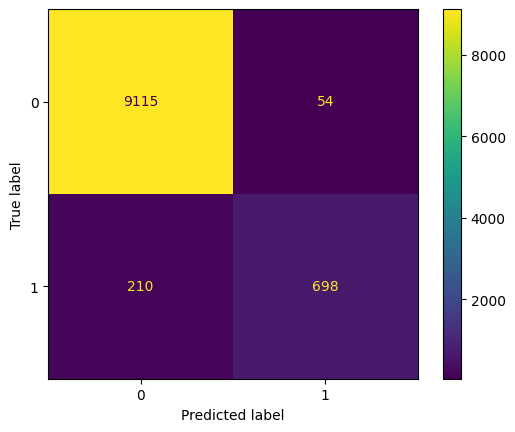

In [46]:
cm_test = metrics.confusion_matrix(test_labels, predictions_test_approx)
print(cm_test)
cm_display = metrics.ConfusionMatrixDisplay(cm_test).plot()
F1 = metrics.f1_score(test_labels, predictions_test_approx, average = 'binary')
print(F1)

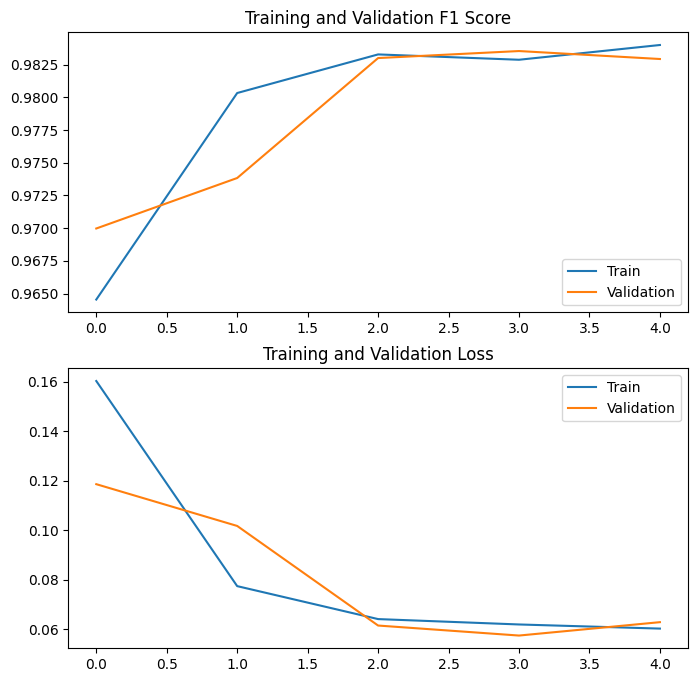

In [47]:
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(CNNparameters["epochs"])

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(range(len(f1_score)), f1_score, label='Train')
plt.plot(range(len(f1_score)), val_f1_score, label='Validation')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')

plt.subplot(2, 1, 2)
plt.plot(range(len(f1_score)), loss, label='Train')
plt.plot(range(len(f1_score)), val_loss, label='Validation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
tp = []
fp = []
fn = []
tn = []

for i in range(len(test_ds)):
    if test_labels[i] == 1 and predictions_test_approx[i] == 1:
        tp.append(i)

for i in range(len(test_ds)):
    if test_labels[i] == 0 and predictions_test_approx[i] == 1:
        fp.append(i)

for i in range(len(test_ds)):
    if test_labels[i] == 1 and predictions_test_approx[i] == 0:
        fn.append(i)

for i in range(len(test_ds)):
    if test_labels[i] == 0 and predictions_test_approx[i] == 0:
        tn.append(i)

In [49]:
# for i in fn:
#     plt.imshow(test_ds[i])
#     plt.colorbar()
#     plt.show()

In [50]:
import sys

original_stdout = sys.stdout # Save a reference to the original standard output

with open('new_results.txt', 'a') as f:
    sys.stdout = f # Change the standard output to the file we created.
    model.summary()
    print("ratio_thr, sum_thr, perc_val, perc_train: ", dataset_parameters)
    print("batch_size, epochs, input_shape, metric,loss_func: ", CNNparameters)
    print(cm_test)
    print("F1 score: ", F1)
    sys.stdout = original_stdout # Reset the standard output to its original value